In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import shap

/home/hfridl/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# creat a DataFrame for the data
df = pd.read_csv('adult.csv')

In [3]:
# check number of null values in each column
df.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [4]:
# information about the dataset, checking features Dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
# sort the categorical and numerical feature headers into two lists
numerical_features = df.select_dtypes(include=['int64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('income') #remove output feature
print(numerical_features)
print(categorical_features)

['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']


In [6]:
# creat input(X) and output(y) dataframe
X = df.drop(columns='income')
y = df['income']
y = y == '>50K'
y.loc[y == True] = 1 
y.loc[y == False] = 0
y = y.astype('int')

In [7]:
# split dataset into train-, validation- and test-set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
print(X_train.shape)
print(X_test.shape)

(39073, 14)
(9769, 14)


In [8]:
# start setup for pre-processing the data
numeric_transformer = 'passthrough'             # leave untransformed
categorical_transformer = Pipeline(steps=[      # setup pipeline for transforming categorical features
    ('categorical_transformer', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
# set up column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

In [10]:
# best_c, best_gamma = 4.6, 'scale'

In [11]:
# Create a pipeline between preprocessor and ML models
rf_model = Pipeline(steps=[('transformed_data', preprocessor),
                      ('classifier', RandomForestClassifier())])
svm_model = Pipeline(steps=[('transformed_data', preprocessor),
                      ('classifier', SVC())])

In [12]:
# fit the models on the full-featured dataset
rf_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

Pipeline(steps=[('transformed_data',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['age', 'fnlwgt',
                                                   'educational-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('categorical',
                                                  Pipeline(steps=[('categorical_transformer',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['workclass', 'education',
                                                   'marital-status',
               

In [13]:
# Model evaluation for RF model
y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_f1score = f1_score(y_test, y_pred)
print(f'RF model')
print(f'accuracy: {rf_accuracy}\nrecall: {rf_recall}\nprecision: {rf_precision}\nf1_score: {rf_f1score}')

RF model
accuracy: 0.8605793837649708
recall: 0.6271986271986272
precision: 0.7478260869565218
f1_score: 0.6822211852543163


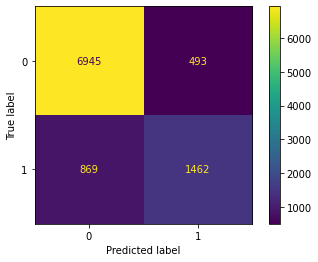

In [14]:
# confusion matrix for RF model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [15]:
# Model evaluation for SVM model
y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_f1score = f1_score(y_test, y_pred)
print(f'SVM model')
print(f'accuracy: {svm_accuracy}\nrecall: {svm_recall}\nprecision: {svm_precision}\nf1_score: {svm_f1score}')

SVM model
accuracy: 0.7976251407513564
recall: 0.15873015873015872
precision: 0.9585492227979274
f1_score: 0.27235921972764077


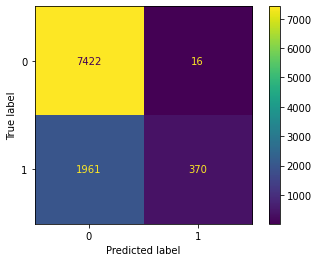

In [16]:
# confusion matrix for SVM model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

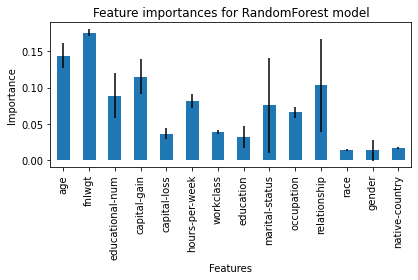

In [17]:
# RF feature importance
rf_feature_importance = rf_model.named_steps['classifier'].feature_importances_

features = numerical_features + categorical_features

forest_importances = pd.Series(rf_feature_importance, index=features)

std = np.std([tree.feature_importances_ for tree in rf_model.named_steps['classifier'].estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances for RandomForest model")
ax.set_ylabel("Importance")
ax.set_xlabel("Features")
fig.tight_layout()

In [18]:
# print feature importance for each feature in precentage for RF model
for feature, importance in zip(features, rf_feature_importance):
    print(f"{feature}: {round(100*importance,3)}%")

age: 14.366%
fnlwgt: 17.564%
educational-num: 8.855%
capital-gain: 11.515%
capital-loss: 3.643%
hours-per-week: 8.127%
workclass: 3.897%
education: 3.191%
marital-status: 7.564%
occupation: 6.567%
relationship: 10.305%
race: 1.382%
gender: 1.36%
native-country: 1.663%


In [19]:
# SVM feature importance train set for SHAP
X_train_shap, unused_test, y_train_shap, unused_test_y = train_test_split(X_train, y_train, train_size=0.03, test_size=0.001)
X_train_shap.shape

(1172, 14)

In [20]:
unused_X, X_test_shap, unused_y, y_test_shap = train_test_split(X_test, y_test, test_size=0.01)
X_test_shap.shape

(98, 14)

In [21]:
# setup model for SHAP
# without pipeline to be able to use SHAP
# transform dataset before to be able to use SHAP
X_transformed_train_shap = pd.DataFrame(preprocessor.fit_transform(X_train_shap), columns=features)
X_transformed_test_shap = pd.DataFrame(preprocessor.fit_transform(X_test_shap), columns=features)
svm_model = SVC(probability=True)
svm_model.fit(X_transformed_train_shap, y_train_shap)

SVC(probability=True)

In [22]:
# use SHAP to calculate feature importances
# transform dataset before input to 
explainer = shap.Explainer(svm_model.predict_proba, X_transformed_train_shap)
shap_values = explainer(X_transformed_test_shap)

Permutation explainer: 99it [03:25,  2.17s/it]                                  


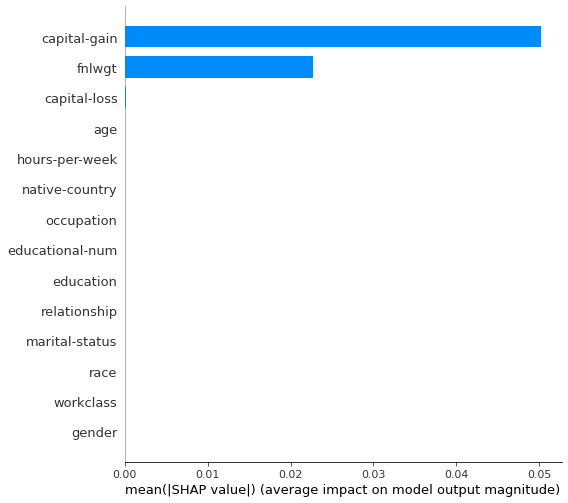

In [23]:
# Visualize the feature importance for both classes
shap.summary_plot(shap_values[:, :, 1], X_transformed_test_shap, plot_type="bar", title="Feature Importance - Rain in Austrailia", max_display=None)

In [27]:
# now drop Humidity3pm as it was the most important feature for both models
features = numerical_features + categorical_features
# RF
X_train_best_removed_rf = X_train.drop(columns=['fnlwgt'])
X_test_best_removed_rf = X_test.drop(columns=['fnlwgt'])
features_best_removed_rf = features.copy()
print(features)
features_best_removed_rf.remove('fnlwgt')
print(features_best_removed_rf)
# SVM
X_train_best_removed_svm = X_train.drop(columns=['capital-gain'])
X_test_best_removed_svm = X_test.drop(columns=['capital-gain'])
features_best_removed_svm = features.copy()
features_best_removed_svm.remove('capital-gain')
print(features_best_removed_svm)

['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
['age', 'fnlwgt', 'educational-num', 'capital-loss', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']


In [28]:
# set up column transformer
# RF
numerical_features_best_removed = numerical_features.copy()
numerical_features_best_removed.remove('fnlwgt')
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numerical_features_best_removed),
        ('categorical', categorical_transformer, categorical_features)
    ])

# SVM
numerical_features_best_removed = numerical_features.copy()
numerical_features_best_removed.remove('capital-gain')
preprocessor_svm = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numerical_features_best_removed),
        ('categorical', categorical_transformer, categorical_features)
    ])

In [30]:
# create a pipeline between preprocessor and ML models
rf_model = Pipeline(steps=[('transformed_data', preprocessor_rf),
                      ('classifier', RandomForestClassifier())])
svm_model = Pipeline(steps=[('transformed_data', preprocessor_svm),
                      ('classifier', SVC())])

In [31]:
# fit the models on the best feature removed dataset
rf_model.fit(X_train_best_removed_rf, y_train)
svm_model.fit(X_train_best_removed_svm, y_train)

Pipeline(steps=[('transformed_data',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['age', 'fnlwgt',
                                                   'educational-num',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('categorical',
                                                  Pipeline(steps=[('categorical_transformer',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
 

In [32]:
# Model evaluation for RF model
y_pred = rf_model.predict(X_test_best_removed_rf)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_f1score = f1_score(y_test, y_pred)
print(f'RF model')
print(f'accuracy: {rf_accuracy}\nrecall: {rf_recall}\nprecision: {rf_precision}\nf1_score: {rf_f1score}')

RF model
accuracy: 0.8540280479066434
recall: 0.6297726297726298
precision: 0.7227966518956179
f1_score: 0.6730857404860157


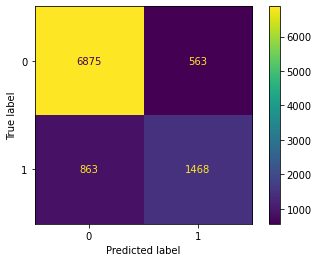

In [33]:
# confusion matrix for RF model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [34]:
# Model evaluation for SVM model
y_pred = svm_model.predict(X_test_best_removed_svm)
svm_accuracy = accuracy_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_f1score = f1_score(y_test, y_pred)
print(f'SVM model')
print(f'accuracy: {svm_accuracy}\nrecall: {svm_recall}\nprecision: {svm_precision}\nf1_score: {svm_f1score}')

SVM model
accuracy: 0.7613880642849831
recall: 0.0
precision: 0.0
f1_score: 0.0


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


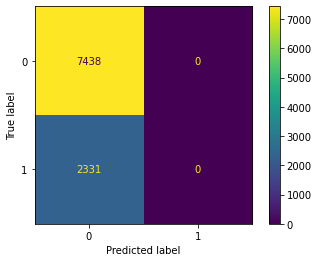

In [35]:
# confusion matrix for SVM model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

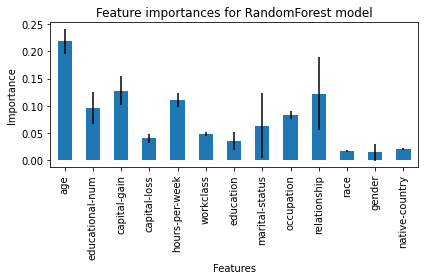

In [36]:
# RF feature importance best feature removed
rf_feature_importance = rf_model.named_steps['classifier'].feature_importances_

# features = numerical_features + categorical_features

forest_importances = pd.Series(rf_feature_importance, index=features_best_removed_rf)

std = np.std([tree.feature_importances_ for tree in rf_model.named_steps['classifier'].estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances for RandomForest model")
ax.set_ylabel("Importance")
ax.set_xlabel("Features")
fig.tight_layout()

In [37]:
# print feature importance for each feature in precentage for RF model
for feature, importance in zip(features_best_removed_rf, rf_feature_importance):
    print(f"{feature}: {round(100*importance,3)}%")

age: 21.816%
educational-num: 9.529%
capital-gain: 12.772%
capital-loss: 4.064%
hours-per-week: 11.074%
workclass: 4.87%
education: 3.488%
marital-status: 6.399%
occupation: 8.357%
relationship: 12.247%
race: 1.737%
gender: 1.517%
native-country: 2.129%


In [38]:
# dataset for shap
X_transformed_train_shap_best_removed = X_transformed_train_shap.drop(columns=['capital-gain'])
X_transformed_test_shap_best_removed = X_transformed_test_shap.drop(columns=['capital-gain'])
svm_model = SVC(probability=True)
svm_model.fit(X_transformed_train_shap_best_removed, y_train_shap)

SVC(probability=True)

In [39]:
# use SHAP to calculate feature importances
# transform dataset before input to 
explainer_best_removed = shap.Explainer(svm_model.predict_proba, X_transformed_train_shap_best_removed)
shap_values_best_removed = explainer_best_removed(X_transformed_test_shap_best_removed)

Permutation explainer: 99it [03:23,  2.14s/it]                                  


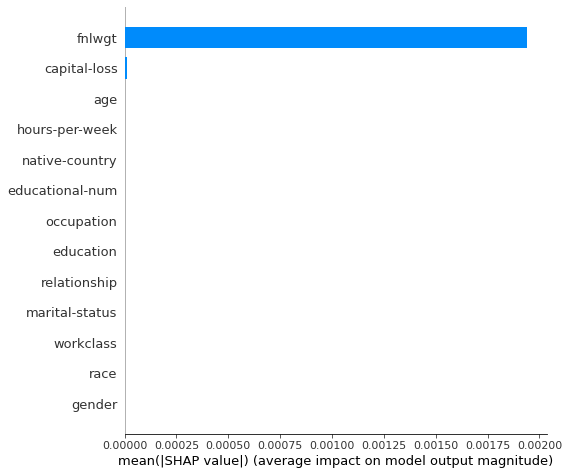

In [40]:
# Visualize the feature importance for both classes
shap.summary_plot(shap_values_best_removed[:, :, 1], X_transformed_test_shap_best_removed, plot_type="bar", title="Feature Importance - rain", max_display=None)